
**[PT]** Para executar este ficheiro veja o ficheiro README.md nesta directoria

**[EN]** To run this file: follow instructions in the README.md file in this directory.

**[PT]** Para criar uma versão `html` sem o código fonte, fazer, na directoria "notebooks":

**[EN]** To create a `html` version without the code cells, do, in the "notebooks" directory:

    jupyter nbconvert students_overview.ipynb --to html --no-input


# **[PT]** Alunos (evolução)
# **[EN]** Students (evolution)

To estimate the reliability of the FA it is necessary to refer to numbers or nominal lists that were obtained directly from the sources, without using the FA as mediation. 

A first step is to chart the evolution of intake. This is relatively easy to do using the initial dates on the records. The “see” type cross-reference records do not show in this graph because, as explained previously, they have no date on record. 

In this notebook we go through the steps to reconstruct the number of students entering and exiting the university, and check the results with data available in the literature.

## **[PT]** Inicialização
## **[EN]** Setup

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from timelinknb import current_time,current_machine, get_mhk_db
import ucalumni.config as alumniconf

db_name = alumniconf.mhk_db_name
db = get_mhk_db(db_name, connect_args={'connect_timeout': 3600})
print(current_machine,current_time,f'db={db_name}')


Timelink utilities for Jupyter notebooks loaded!
imac-jrc 2022-05-11 16:50:51.313983 db=ucalumni


## **[PT]** Cobertura
## **[EN]** Coverage

Query the attributes table using attributes `uc-entrada.ano` and `uc-saida.ano`. 

These attributes have as values the year of the first date and last date on the record, as supplied
by the metadata information on the Archeevo system (fields _unitDateInitial_ and _unitDate_final_). 

Note that cross-reference records ("vide") that do not contain a valid date 
"see" references, are not included in these calculations.

In [2]:
from sqlalchemy import select, func, and_

from timelinknb import get_attribute_table
from timelinknb.config import Session

attr_table = get_attribute_table()

stmt = select(func.count(attr_table.c.entity.distinct()).label('dated_records')).\
              where(attr_table.c.the_type == 'uc-entrada.ano')

with Session() as session:
    dated_records = session.execute(stmt).scalar()      

print("Number of students with entry date", dated_records)

stmt = select(func.count(attr_table.c.entity.distinct()).label('vide_records')).\
              where(and_(attr_table.c.the_type == 'uc-entrada'),
                         attr_table.c.the_value == '0000-00-00')

with Session() as session:
    n_vide = session.execute(stmt).scalar()           


print("Number of zero date records (to be ignored)", n_vide)


Number of students with entry date 99535
Number of zero date records (to be ignored) 5763


### **[EN]** Students and parents

Nearly 50.000 students are identified with their father's name. 

Mother names were added to some records as a result of analysing some age certificates, after the original records were produced.

In the database, fathers and mothers are recorded with functions "referido" and "referida" respectively.

In [3]:
from sqlalchemy import and_, or_
from timelinknb import get_nfuncs_view 

nfuncs = get_nfuncs_view()

stmt = select(nfuncs.c['func'].label('funcao'), 
        func.count(nfuncs.c.id.distinct()).label('n')).\
            group_by("func").order_by("func")

print(stmt)

with Session() as session:
    functions = session.execute(stmt)    

for f in functions:
    print(f.funcao,f.n)

SELECT nfuncs.func AS funcao, count(DISTINCT nfuncs.id) AS n 
FROM nfuncs GROUP BY nfuncs.func ORDER BY nfuncs.func
n 105298
referida 93
referido 49916


### **[EN]** Students entering the university

Using the first and last date on record an estimate of number of first matriculations can be made.


In [4]:
from sqlalchemy import select, func
import pandas as pd

from timelinknb import get_attribute_table
from timelinknb.config import Session

attr_table = get_attribute_table()
# Totais de estudantes por ano de entrada
stmt = select(attr_table.c.the_value.label('ano'), 
        func.count(attr_table.c.id.distinct()).label('entradas')).\
            where(attr_table.c.the_type == "uc-entrada.ano").\
            group_by("the_value").order_by("the_value")

with Session() as session:
    entradas_por_ano = session.execute(stmt)
    entradas_df = pd.DataFrame.from_records(entradas_por_ano,index=['ano'],columns=['ano','entradas'])
    entradas_df.index = entradas_df.index.astype(int)

print()
print("First values:")
print(entradas_df.head(5))
print("Last values:")
print(entradas_df.tail(5))



First values:
      entradas
ano           
1536         2
1537       201
1538       161
1539        33
1540       487
Last values:
      entradas
ano           
1913        41
1914         7
1915         4
1916         5
1917         2


### **[EN]** Students exiting the university

Also, by using the last year on record we can infer a date of exit from the university.
We count the exits in the year after they occurred, e.g.,the total of students with last date in
1538 is registered in 1539, meaning, they are no longer in the FA in 1539.

These number are affected by duplicate records and will improve in accuray as they are
resolved.

In [5]:
from timelinknb import get_attribute_table
from timelinknb.config import Session

# Totais de estudantes por ano de saída
stmt = select(attr_table.c.the_value.label('ano'), 
        func.count(attr_table.c.id.distinct()).label('saidas')).\
            where(attr_table.c.the_type == "uc-saida.ano").\
            group_by("the_value").order_by("the_value")

with Session() as session:
    saidas_por_ano = session.execute(stmt)
    saidas_df = pd.DataFrame.from_records(saidas_por_ano,index=['ano'],columns=['ano','saidas'])
    saidas_df.index = saidas_df.index.astype(int)

print("We consider that the student exits in the year subsequent to the last date on record")
saidas_df.index = saidas_df.index + 1
print()
print("First values:")
print(saidas_df.head(5))
print("Last values:")
print(saidas_df.tail(5))

We consider that the student exits in the year subsequent to the last date on record

First values:
      saidas
ano         
1538      84
1539      95
1540      35
1541     415
1542      80
Last values:
      saidas
ano         
1923       3
1924       2
1926       3
1927       1
1928       5


**[EN]** We now join the two series to obtain a table with number of students "entered" and number of students "exited" per year.

In [6]:

estudantes = pd.concat([entradas_df,saidas_df],axis=1).sort_index()
estudantes.fillna(0,inplace=True)
print(estudantes.info())
estudantes['presentes'] = (estudantes.entradas-estudantes.saidas).cumsum()

print()

print(estudantes.head(5))
print(estudantes.tail(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 1536 to 1928
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   entradas  391 non-null    float64
 1   saidas    391 non-null    float64
dtypes: float64(2)
memory usage: 9.2 KB
None

      entradas  saidas  presentes
ano                              
1536       2.0     0.0        2.0
1537     201.0     0.0      203.0
1538     161.0    84.0      280.0
1539      33.0    95.0      218.0
1540     487.0    35.0      670.0
      entradas  saidas  presentes
ano                              
1923       0.0     3.0       12.0
1924       0.0     2.0       10.0
1926       0.0     3.0        7.0
1927       0.0     1.0        6.0
1928       0.0     5.0        1.0


# **[PT]** Evolução das entradas
# **[EN]** Evolution of intake

In [7]:
plt.rcParams["figure.figsize"] = [12, 5]

In [8]:
estudantes['entradas'].head()

ano
1536      2.0
1537    201.0
1538    161.0
1539     33.0
1540    487.0
Name: entradas, dtype: float64

<AxesSubplot:xlabel='ano'>

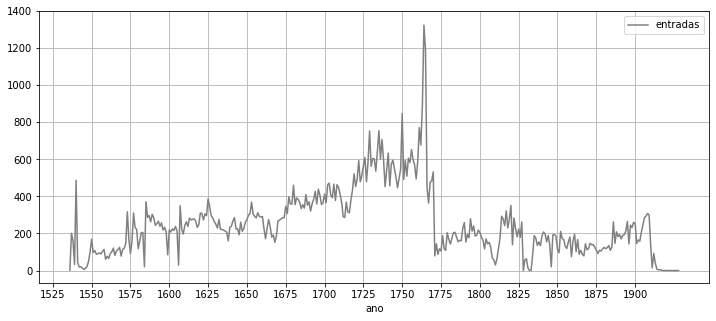

In [10]:
anos = range(1525,1921,25)
valores = range(0,1401,200)
estudantes.plot.line(color=['grey'],y='entradas',xticks=anos, yticks=valores, grid=True)

## **[EN]** Comparing with external data

### **[EN]** Compare first matriculations

Comparing with

> Fonseca, F.T. da (2007) ‘The social and cultural roles of the University of Coimbra (1537-1820): some considerations’, e-journal of Portuguese History, Vol:5(Num:1). Available at: https://digitalis-dsp.uc.pt/jspui/handle/10316.2/25364 (Accessed: 2 April 2020).

Important: the chart is based on enrollment in Canon and Civil Law only, which corresponds to 87.3% of the total number of students, in average. "The figures used here for ‘freshmen’ in Canon and Civil Law were obtained directly from archive records (Arquivo da Universidade de Coimbra, _Livros de Matrículas_) and, for the period 1772 -1820, from Manuel Alberto Carvalho Prata, _Ciência e Sociedade. A faculdade de Filosofia no período pombalino e pós -pombalino (1772-1820)_, Guarda, 1989." p.5, n.16.


![Chart1](./images/taveira_2007_5.png)



<AxesSubplot:xlabel='ano'>

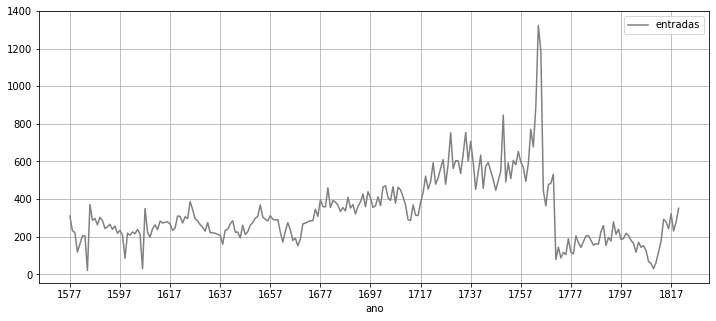

In [11]:
anos = [1577,1597,1617,1637,1657,1677,1697,1717,1737,1757,1777,1797,1817]
valores = [0,200,400,600,800,1000,1200,1400]
estudantes.loc[1577:1820].plot.line(color=['grey'], y='entradas',xticks=anos, yticks=valores,grid=True)

### **[EN]** Student population

Comparing with:

Fonseca, Fernando Taveira da. A Universidade de Coimbra 1700-1771: Estudo Social e Económico. Acta Universitatis Conimbrigensis. Coimbra: Por Ordem da Universidade, 1995.
Chapter I, table pp. 31-32

In [12]:
fonseca_1995 = pd.read_csv('../extras/validation/fonseca_1995_students.csv',sep=";", index_col='Anos')
print(fonseca_1995.head())
if 'fonseca' in estudantes.columns:
    estudantes = estudantes.drop(['fonseca'],axis=1)
estudantes.loc[fonseca_1995.index.values,'fonseca'] =  fonseca_1995.values
estudantes.loc[1700:].head()

      Total
Anos       
1700   1610
1701   1664
1702   1657
1703   1750
1704   1844


,entradas,saidas,presentes,fonseca
ano,,,,
1700,412.0,389.0,2113.0,1610.0
1701,365.0,379.0,2099.0,1664.0
1702,464.0,392.0,2171.0,1657.0
1703,471.0,448.0,2194.0,1750.0
1704,407.0,481.0,2120.0,1844.0


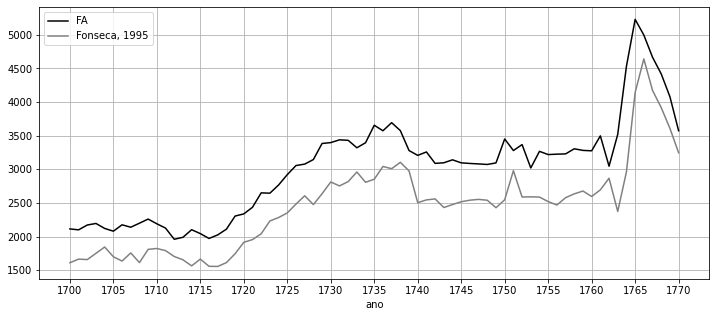

In [13]:
import matplotlib.pyplot as plt

anos = list(range(1700,1771,5))
valores = list(range(0,1401,200))
estudantes.loc[1700:1770,['presentes','fonseca']].plot(color=['black','grey'],xticks=anos,grid=True)
plt.legend(['FA','Fonseca, 1995'])

**[EN]** Note that FA derived curve seems shifted one year earlier.

It is not clear why that is so.

Try shifting FA values one year ahead.

In [14]:
estudantes['shifted']=estudantes['presentes'].shift(1)

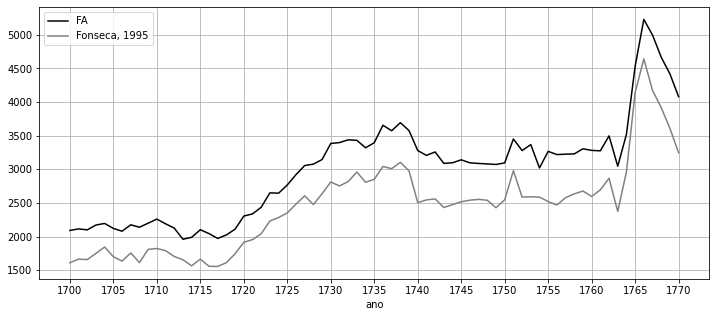

In [15]:
import matplotlib.pyplot as plt

estudantes.loc[1700:1770,['shifted','fonseca']].plot(color=['black','grey'],xticks=anos,grid=True)
plt.legend(['FA','Fonseca, 1995'])

**[EN]** Compute trend line and correlation coeficient

In [16]:
import numpy.polynomial.polynomial as poly

fit,residuals = poly.polyfit(estudantes.loc[1700:1770,'fonseca'],estudantes.loc[1700:1770,'shifted'],1,full=True)
eq = poly.Polynomial(fit)
if 'rline' in estudantes.columns:
    estudantes=estudantes.drop('rline',axis=1)
    
estudantes.insert(len(estudantes.columns),'rline',eq(estudantes['fonseca']))
estudantes.loc[1700:1770].head()
print(f"trend line: {eq}")

trend line: 258.22406334649287 + 1.1153844783297795·x¹


**[EN]** Getting the correlation coeficient is a bit complicated.

See https://stackoverflow.com/questions/58986593/np-poly1d-how-to-calculate-r2

In [17]:
SSE = residuals[0]
diff = estudantes.loc[1700:1770,'fonseca'] - estudantes.loc[1700:1770,'fonseca'].mean()
square_diff = diff ** 2
SST = square_diff.sum()
R2 = 1- SSE/SST
print("Correlation coeficient",R2)

Correlation coeficient [0.97414047]


**[EN]** Plot the correlation

y=1.12x+258.22 (r2=0.97)


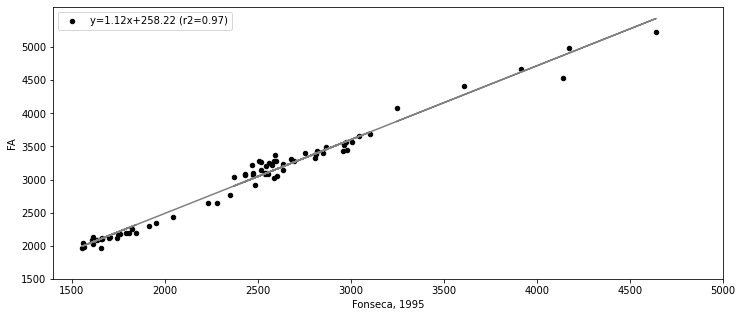

In [19]:
ax=estudantes.loc[1700:1770].plot.scatter(
                        color=['black'],
                        xticks=range(1500,5200,500),
                        yticks=range(1500,5200,500),
                        x='fonseca', 
                        y='shifted')
estudantes.loc[1700:1770].plot(
                        color=['grey'],
                        xticks=range(1500,5200,500),
                        yticks=range(1500,5200,500),
                        x='fonseca', 
                        y='rline',
                        ax=ax)
ax.set_ylabel('FA')
ax.set_xlabel('Fonseca, 1995')
m = float(list(eq)[0])
a = float(list(eq)[1])
label = f"y={a:.2f}x+{m:.2f} (r2={float(R2):.2f})"
print(label)
plt.legend([label])

**[EN]** Compute the percent increase of the FA totals

In [27]:
estudantes['perc_FA']=estudantes['shifted']/estudantes['fonseca']-1
estudantes.loc[1700:1770].head()

,entradas,saidas,presentes,fonseca,shifted,rline,perc_FA
ano,,,,,,,
1700,412.0,389.0,2113.0,1610.0,2090.0,2053.993073,0.298137
1701,365.0,379.0,2099.0,1664.0,2113.0,2114.223835,0.269832
1702,464.0,392.0,2171.0,1657.0,2099.0,2106.416144,0.266747
1703,471.0,448.0,2194.0,1750.0,2171.0,2210.146900,0.240571
1704,407.0,481.0,2120.0,1844.0,2194.0,2314.993041,0.189805


Average increase of estimate from FA: 0.23, max: 0.33, min: 0.094


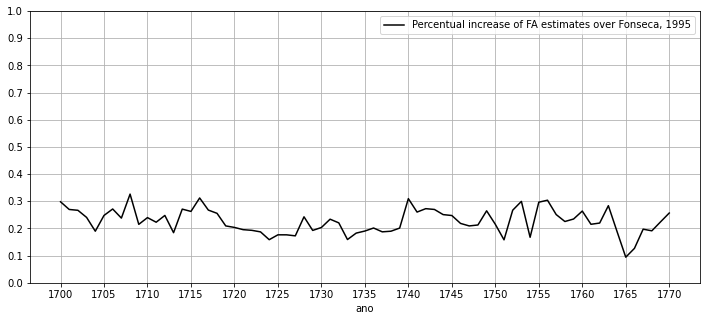

In [34]:
import numpy as np

mean_diff = estudantes.loc[1700:1770,'perc_FA'].mean()
max_diff = estudantes.loc[1700:1770,'perc_FA'].max()
min_diff = estudantes.loc[1700:1770,'perc_FA'].min()

print(f"Average increase of estimate from FA: {mean_diff:.2}, max: {max_diff:.2}, min: {min_diff:.2}")
yvalues = np.linspace(0,1,11)
estudantes.loc[1700:1770,['perc_FA']].plot(color=['black'],xticks=anos,yticks=yvalues,grid=True)
plt.legend(["Percentual increase of FA estimates over Fonseca, 1995"])

## **[PT]** Entradas, média movel de 5 anos
## **[EN]** Intake, 5 year moving average

In [32]:
estudantes['entradas_mm_5']=estudantes['entradas'].rolling(window=5,center=True).mean()

,entradas,saidas,presentes,entradas_mm_5
ano,,,,
1536,2.0,0.0,2.0,NaN
1537,201.0,0.0,203.0,NaN
1538,161.0,84.0,280.0,176.8
1539,33.0,95.0,218.0,185.0
1540,487.0,35.0,670.0,148.6
1541,43.0,415.0,298.0,120.6
1542,19.0,80.0,237.0,116.6
1543,21.0,43.0,215.0,20.4
1544,13.0,33.0,195.0,14.4


<AxesSubplot:xlabel='ano'>

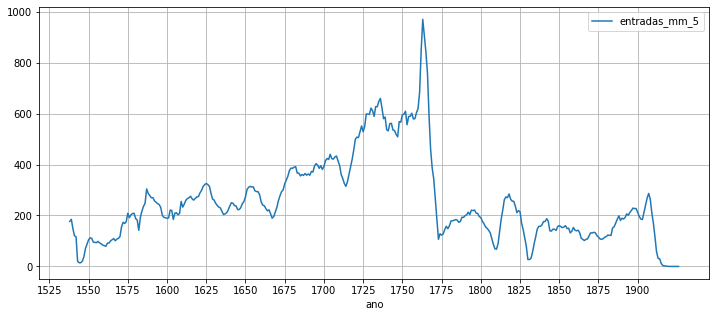

In [33]:
anos = list(range(1525,1921,25))
estudantes.plot.line(y='entradas_mm_5',xticks=anos, grid=True)

### Detalhe

In [36]:
pd.set_option('display.max_rows',500)
estudantes.loc[1700:1771]

,entradas,saidas,presentes,entradas_mm_5
ano,,,,
1700,412.0,389.0,2113.0,392.2
1701,365.0,379.0,2099.0,415.2
1702,464.0,392.0,2171.0,423.8
1703,471.0,448.0,2194.0,420.0
1704,407.0,481.0,2120.0,440.2
1705,393.0,434.0,2079.0,423.0
1706,466.0,371.0,2174.0,421.4
1707,378.0,414.0,2138.0,429.8
1708,463.0,403.0,2198.0,433.6


<AxesSubplot:xlabel='ano'>

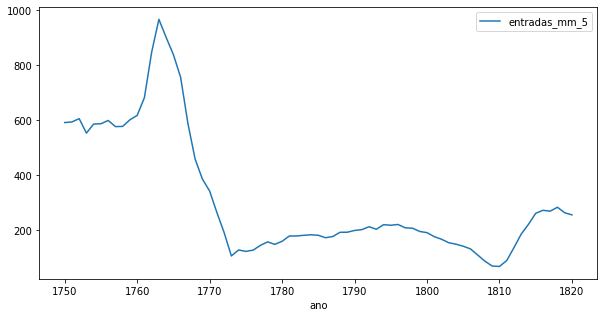

In [48]:
estudantes.loc[1750:1820].plot.line(y='entradas_mm_5')

# **[PT]** Cálculo da população estudantil
# **[EN]** Estimating the student population

**[PT]** Usamos as datas limites da ficha de cada aluno para calcular os totais entrados e saídos por ano (considera-se ano de saída o ano a seguir à ultima data no registo)

**[EN]** We use the first and last date of each student record to compute the total incoming and total outgoing per year (considering the year after the last date on record to be the outgoing year)

<AxesSubplot:xlabel='ano'>

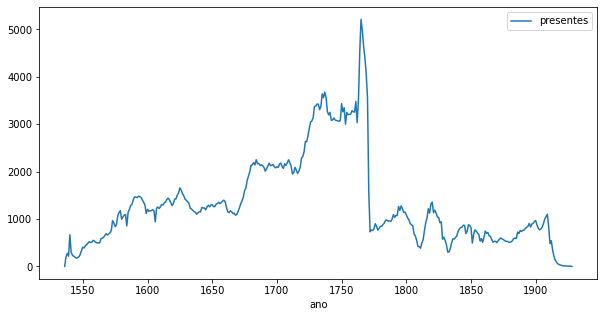

In [49]:
estudantes.plot.line(y='presentes')

# População estudantil e reforma pombalina

<AxesSubplot:xlabel='ano'>

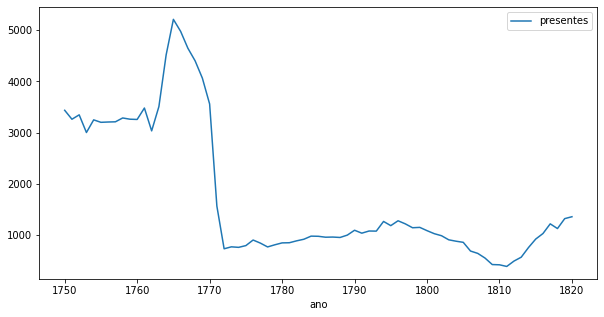

In [50]:
estudantes.loc[1750:1820].plot.line(y='presentes')

# União ibérica 

Evolução entre 1540 e 1680

<AxesSubplot:xlabel='ano'>

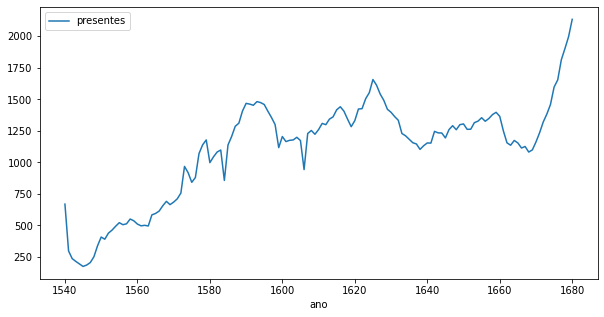

In [51]:
estudantes.loc[1540:1680].plot.line(y='presentes')

# Números globais

Nota: "saídas" corresponde ao total de estudantes cuja última data registada na documentação ocorreu no ano anterior.

In [52]:
pd.set_option('display.max_rows',500)
estudantes

,entradas,saidas,presentes,entradas_mm_5
ano,,,,
1536,2.0,0.0,2.0,NaN
1537,199.0,0.0,201.0,NaN
1538,161.0,83.0,279.0,176.4
1539,33.0,95.0,217.0,184.6
1540,487.0,35.0,669.0,148.6
1541,43.0,414.0,298.0,120.6
1542,19.0,80.0,237.0,116.6
1543,21.0,43.0,215.0,20.4
1544,13.0,33.0,195.0,14.4


## **[PT]** Validações

### **[PT]** Comparar com mapas estatísticos de Vasconcelos

#### **[PT]** Número de alunos matriculados na Universidade de Coimbra nos Anos de 1537-38 a 1540-41

Escritos Vários, vol.II, p. 117-118

In [19]:
from timelinknb.pandas import attribute_to_df


# Get list of people with a given attribute type, extra columns
alunos_1537_38 = attribute_to_df(
                    the_type='uc-entrada.ano',
                    the_value='1537',
                    person_info=True,
                    more_cols=['faculdade'],
                    sql_echo=True)
alunos_1538_39 = attribute_to_df(
                    the_type='uc-entrada.ano',
                    the_value='1538',
                    person_info=True,
                    more_cols=['faculdade'],
                    sql_echo=True)
alunos_1539_40 = attribute_to_df(
                    the_type='uc-entrada.ano',
                    the_value='1539',
                    person_info=True,
                    more_cols=['faculdade'],
                    sql_echo=True)
alunos_1540_41 = attribute_to_df(
                    the_type='uc-entrada.ano',
                    the_value='1540',
                    person_info=True,
                    more_cols=['faculdade'],
                    sql_echo=True)

alunos_1537_41 = pd.concat([alunos_1537_38,alunos_1538_39,alunos_1539_40,alunos_1540_41])

Query for uc-entrada.ano:
 SELECT nattributes.id, nattributes.name AS nome, nattributes.sex AS sexo, nattributes.the_value AS uc_entrada_ano, nattributes.the_date AS uc_entrada_ano_date, nattributes.aobs AS uc_entrada_ano_obs 
FROM nattributes 
WHERE nattributes.the_type = :the_type_1 AND nattributes.the_value LIKE :the_value_1 ORDER BY nattributes.the_date
Query for uc-entrada.ano:
 SELECT nattributes.id, nattributes.name AS nome, nattributes.sex AS sexo, nattributes.the_value AS uc_entrada_ano, nattributes.the_date AS uc_entrada_ano_date, nattributes.aobs AS uc_entrada_ano_obs 
FROM nattributes 
WHERE nattributes.the_type = :the_type_1 AND nattributes.the_value LIKE :the_value_1 ORDER BY nattributes.the_date
Query for uc-entrada.ano:
 SELECT nattributes.id, nattributes.name AS nome, nattributes.sex AS sexo, nattributes.the_value AS uc_entrada_ano, nattributes.the_date AS uc_entrada_ano_date, nattributes.aobs AS uc_entrada_ano_obs 
FROM nattributes 
WHERE nattributes.the_type = :the_t

In [20]:
alunos_1537_41[['uc_entrada_ano','faculdade','nome','faculdade_obs']].sort_values(['uc_entrada_ano','faculdade','nome','faculdade_obs']).head(20)

,uc_entrada_ano,faculdade,nome,faculdade_obs
id,,,,
251448,1537,(?),Luís Luís,None
163264,1537,Artes,Diogo,None
172585,1537,Artes,João Lopes Galiano,João Lopes Galiano (padre)
247958,1537,Artes,Simão Fernandes,*no-field-line*: Bacharel em Artes 06.03.1542
251548,1537,Cânones,Afonso Luís,Cânones
248760,1537,Cânones,Afonso Pires,Cânones
211564,1537,Cânones,Afonso Vaz,Cânones
211389,1537,Cânones,Aires Gomes de Sá,None
248294,1537,Cânones,André Fernandes,Cânones


In [21]:
alunos_1537_41[['uc_entrada_ano','faculdade','nome','faculdade_obs']].sort_values(['uc_entrada_ano','faculdade','nome','faculdade_obs']).tail(20)

,uc_entrada_ano,faculdade,nome,faculdade_obs
id,,,,
151911,1540,NaN,Manuel de Barros,NaN
251377,1540,NaN,Manuel de Morais,NaN
144581,1540,NaN,Manuel Álvares,NaN
253591,1540,NaN,Mateus Lopes,NaN
247379,1540,NaN,Miguel Fernandes,NaN
189697,1540,NaN,Paulo da Rocha,NaN
170975,1540,NaN,Pedro Alves da Nobrega,NaN
247434,1540,NaN,Pedro Fernandes,NaN
247438,1540,NaN,Pedro Fernandes,NaN


In [22]:
alunos_1537_41.loc['174785']

nome                   Cristóvão de Melo
sexo                                   m
uc_entrada_ano                      1540
uc_entrada_ano_date           1540-11-03
uc_entrada_ano_obs                  None
faculdade                            NaN
faculdade_date                       NaN
faculdade_obs                        NaN
Name: 174785, dtype: object

![Vasconcelos. Escritos vários, 2, p.117](./images/vasconcelos_ev2_117.png)
![Vasconcelos. Escritos vários, 2, p.118](./images/vasconcelos_ev2_118.png)

### **[PT]** Usando as data iniciais (novos alunos)

In [23]:
alunos_1537_41[['uc_entrada_ano','nome']].groupby(['uc_entrada_ano']).count()

,nome
uc_entrada_ano,
1537,206
1538,164
1539,35
1540,504


In [78]:
alunos_1537_41[['uc_entrada_ano','faculdade','nome']].groupby(['uc_entrada_ano','faculdade']).count()

nome
uc_entrada_ano faculdade                      
1537           (? (Gramática))               1
               (?)                           1
               Artes                         3
               Cânones                      73
               Direito (Cânones ou Leis)     3
               Leis                         82
               Medicina                      7
               Teologia                      3
1538           Cânones                      66
               Direito (Cânones ou Leis)     1
               Leis                         90
               Medicina                      2
1539           Cânones                      17
               Leis                         18
1540           (Codigo)                      1
               (Código)                     12
               (Dialética)                   5
               (Filosofia)                  12
               (Granática)                   1
               (Teorico)                     2
               (Teórico)                     2
               (Teóricos)                    1
               Artes                        18
               Cânones                     117
               Direito (Cânones ou Leis)    38
               Leis                        150
               Medicina                     22
               Teologia                     18